# TextRank algorithm

1.TextRank is an extractive summarization technique.

2.It is based on the concept that words which occur more frequently are significant.

3.Hence , the sentences containing highly frequent words are important .

4.Based on this , the algorithm assigns scores to each sentence in the text . 

5.The top-ranked sentences make it to the summary.

pip install PyMuPDF
pip install frontend
pip install pdfplumber
pip install PyMuPDF
pip install fitz
pip install rouge==1.0.0
pip install streamlit==0.80.0
pip install gensim==4.0.1
pip install altair==4.1.0
pip install pandas==1.2.3
pip install sumy==0.8.1
pip install gensim==3.8.3

In [1]:
#pip install bs4

In [2]:
#pip install bert-score

In [52]:
import numpy
import tensorflow as tf 
##Print many staement at same time using the below command
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
#pip install PyMuPDF
import fitz
import glob
import pdfplumber
import re

#pip install sacrebleu
import re
from bs4 import BeautifulSoup
from nltk.translate.bleu_score import sentence_bleu
import gensim
from gensim.summarization import summarize
from rouge import Rouge


import bert_score
from bert_score import score
import matplotlib.pyplot as plt
from bert_score import BERTScorer

In [5]:
F1_textrank=''
F1_luhan=''
F1_kl=''
F1_lex=''
F1_lsa=''

In [6]:
pdf_dir = "./data"

pdf_files = glob.glob("%s/*.pdf" % pdf_dir)
all_abstracts = ""
for filename in pdf_files:
    print("+++++++++++++++++++++++++++++++++++++++++++",filename)
    doc = fitz.open(filename)
    print ("number of pages: %i" % doc.pageCount)

    page1 = doc.loadPage(0)
    page1text = page1.getText("text")

    page2 = doc.loadPage(1)
    page2text = page2.getText("text")

    try:
        try:
            Abstract = page1text.split("Introduction",1)[1]
            partitioned_string = page2text.split('Data')[0]
        except:
            Abstract = page1text.split("Introduction",1)[1]
            partitioned_string = Abstract.split('Data')[0]
    except Exception as IndexError:
        try:
            Abstract = page2text.split("Introduction",1)[1]
            partitioned_string = Abstract.split('Data')[0]
        except:
            Abstract = page2text.split("Introduction",1)[1]
            partitioned_string = Abstract.split('Data')[0]
    partitioned_string = re.sub('\S+@\S+',"",partitioned_string)
    partitioned_string = re.sub(r'[0-9]',"",partitioned_string)
    #partitioned_string = " ".join(re.findall(r"[a-zA-Z0-9]+",partitioned_string ))
    all_abstracts += partitioned_string

+++++++++++++++++++++++++++++++++++++++++++ ./data/1811.12015.pdf
number of pages: 19
+++++++++++++++++++++++++++++++++++++++++++ ./data/2006.12720.pdf
number of pages: 16
+++++++++++++++++++++++++++++++++++++++++++ ./data/2106.07909 (1).pdf
number of pages: 22


In [7]:
def clean_text(text):
    text = BeautifulSoup(text, "lxml").get_text()
    # Removing the @
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
    # Removing the URL links
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    # Keeping only letters
    text = re.sub(r"[^a-zA-Z.!?']", ' ', text)
    # Removing additional whitespaces
    text = re.sub(r" +", ' ', text)
    return text

In [8]:
original_text = all_abstracts 

In [9]:
textRank_summary = summarize(original_text)

## Matrices Evalution

### Rouge

In [10]:
r = Rouge()
score_text=r.get_scores(textRank_summary, original_text)

In [11]:
file = open('textRank__org.txt', 'w')
file.write(original_text)
file.close()

file = open('textRank_hyps.txt', 'w')
file.write(textRank_summary)
file.close()

In [12]:
with open("textRank_hyps.txt") as f:
    cands = [line.strip() for line in f]

with open("textRank__org.txt") as f:
    refs = [[line.strip() for line in f]]

### Blue Score

In [13]:
blue_score_textrank=sentence_bleu(refs, cands)
print('BLEU score -> {}'.format(sentence_bleu(refs, cands)))

BLEU score -> 5.037094777266818e-156


/opt/anaconda3/envs/NLG/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)

/opt/anaconda3/envs/NLG/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)



In [14]:
print('Individual 1-gram: %f' % sentence_bleu(refs, cands, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(refs, cands, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(refs, cands, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(refs, cands, weights=(0, 0, 0, 1)))

Individual 1-gram: 0.039184
Individual 2-gram: 0.006369
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000


### Bert Score

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


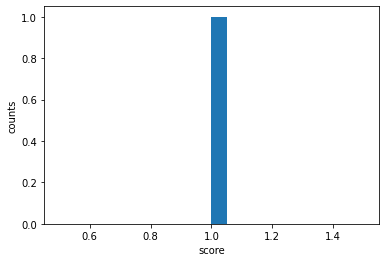

In [15]:
if len(cands)==1:
    P, R, F1 = score(cands, refs, lang='en', rescale_with_baseline=True)
    F1_textrank=F1
    plt.hist(F1, bins=20)
    plt.xlabel("score")
    plt.ylabel("counts")
    plt.show()

if len(cands)>1:
    scorer = BERTScorer(lang="en", rescale_with_baseline=True)
    P, R, F1 = scorer.score(cands, refs)
    F1_textrank=F1
    plt.hist(F1, bins=20)
    plt.xlabel("score")
    plt.ylabel("counts")
    plt.show()

# Text Summarization with Sumy


# LexRank
1.A sentence which is similar to many other sentences of the text has a high probability of being important. 

2.The approach of LexRank is that a particular sentence is recommended by other similar sentences and hence is ranked higher.

3.Higher the rank, higher is the priority of being included in the summarized text.

In [16]:
# Importing the parser and tokenizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer

In [17]:
# Initializing the parser
my_parser = PlaintextParser.from_string(original_text,Tokenizer('english'))

In [18]:
# Import the LexRank summarizer
from sumy.summarizers.lex_rank import LexRankSummarizer

In [19]:
# Creating a summary of 3 sentences.
lex_rank_summarizer = LexRankSummarizer()
lexrank_summary = lex_rank_summarizer(my_parser.document,sentences_count=10)

lex_summary = ""
# Printing the summary
for sentence in lexrank_summary:
    lex_summary +=str(sentence)

### Matrices Evaluation

### Rouge Score

In [20]:
r = Rouge()
score_lexRank=r.get_scores(lex_summary, original_text)

In [21]:
file = open('lexRank_hyps.txt', 'w')
file.write(lex_summary)
file.close()

In [22]:
with open("lexRank_hyps.txt") as f:
    cands_lex = [line.strip() for line in f]

### Blue Score

In [24]:
blue_score_lex=sentence_bleu(refs, cands_lex)
print('BLEU score -> {}'.format(sentence_bleu(refs, cands_lex)))


BLEU score -> 0


### Bert Score

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


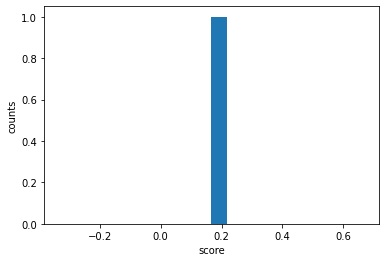

In [28]:
if len(cands_lex)==1:
    P, R, F1 = score(cands_lex, refs, lang='en', rescale_with_baseline=True)
    F1_lex=F1
    plt.hist(F1, bins=20)
    plt.xlabel("score")
    plt.ylabel("counts")
    plt.show()
if len(cands_lex)>1:
    scorer = BERTScorer(lang="en", rescale_with_baseline=True)
    P, R, F1 = scorer.score(cands_lex, refs)
    F1_lex=F1
    plt.hist(F1, bins=20)
    plt.xlabel("score")
    plt.ylabel("counts")
    plt.show()

# LSA (Latent semantic analysis)
Latent Semantic Analysis is a unsupervised learning algorithm that can be used for extractive text summarization.

It extracts semantically significant sentences by applying singular value decomposition(SVD) to the matrix of term-document frequency.

In [29]:
# Import the summarizer
from sumy.summarizers.lsa import LsaSummarizer

In [30]:
# creating the summarizer
lsa_summarizer=LsaSummarizer()
lsa_summary= lsa_summarizer(my_parser.document,10)
lsa_summary_text = ""
# Printing the summary
for sentence in lsa_summary:
    lsa_summary_text +=str(sentence)

## Matrices Evalution 

Roug Score:
BLEU score -> 0
Bert Score:


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


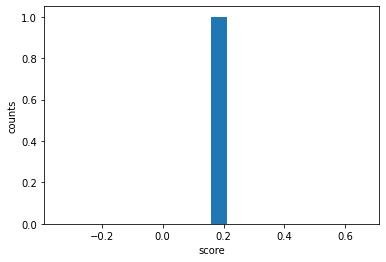

In [32]:
print("Roug Score:")
r = Rouge()
score_lsa=r.get_scores(lsa_summary_text, original_text)

file = open('lsaRank__org.txt', 'w')
file.write(original_text)
file.close()

file = open('lsaRank_hyps.txt', 'w')
file.write(lsa_summary_text)
file.close()


with open("lsaRank_hyps.txt") as f:
    cands_lsa = [line.strip() for line in f]

with open("lsaRank__org.txt") as f:
    refs_lsa = [[line.strip() for line in f]]


print('BLEU score -> {}'.format(sentence_bleu(refs_lsa, cands_lex)))
blue_score_lsa=sentence_bleu(refs_lsa, cands_lex)

print("Bert Score:")
if len(cands_lsa)==1:
    P, R, F1 = score(cands_lsa, refs_lsa, lang='en', rescale_with_baseline=True)
    F1_lsa=F1
    plt.hist(F1, bins=20)
    plt.xlabel("score")
    plt.ylabel("counts")
    plt.show()
if len(cands_lsa)>1:
    scorer = BERTScorer(lang="en", rescale_with_baseline=True)
    P, R, F1 = scorer.score(cands_lsa, refs_lsa)
    F1_lsa=F1
    plt.hist(F1, bins=20)
    plt.xlabel("score")
    plt.ylabel("counts")
    plt.show()

# Luhn

Luhn Summarization algorithm’s approach is based on TF-IDF (Term Frequency-Inverse Document Frequency). It is useful when very low frequent words as well as highly frequent words(stopwords) are both not significant.

Based on this, sentence scoring is carried out and the high ranking sentences make it to the summary.

In [33]:
# Import the summarizer
from sumy.summarizers.luhn import LuhnSummarizer

In [34]:
#  Creating the summarizer
luhn_summarizer = LuhnSummarizer()
luhn_summary = luhn_summarizer(my_parser.document,sentences_count=10)

summary_luhn = ""
# Printing the summary
for sentence in luhn_summary:
    summary_luhn +=str(sentence)

In [35]:
print("Roug Score:")
r = Rouge()
score_luhan=r.get_scores(summary_luhn, original_text)

Roug Score:


BLEU score -> 0
Bert Score:


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


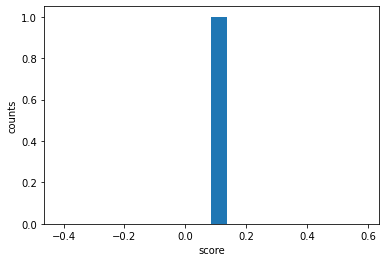

In [36]:


file = open('luhan__org.txt', 'w')
file.write(original_text)
file.close()

file = open('luhan_hyps.txt', 'w')
file.write(summary_luhn)
file.close()


with open("luhan_hyps.txt") as f:
    cands_luhan = [line.strip() for line in f]

with open("luhan__org.txt") as f:
    refs_luhan = [[line.strip() for line in f]]


print('BLEU score -> {}'.format(sentence_bleu(refs_luhan, cands_luhan)))
blue_score_luhan=sentence_bleu(refs_luhan, cands_luhan)

print("Bert Score:")
if len(cands_luhan)==1:
    P, R, F1 = score(cands_luhan, refs_luhan, lang='en', rescale_with_baseline=True)
    F1_luhan=F1
    plt.hist(F1, bins=20)
    plt.xlabel("score")
    plt.ylabel("counts")
    plt.show()
if len(cands_luhan)>1:
    scorer = BERTScorer(lang="en", rescale_with_baseline=True)
    P, R, F1 = scorer.score(cands_luhan, refs_luhan)
    F1_luhan=F1
    plt.hist(F1, bins=20)
    plt.xlabel("score")
    plt.ylabel("counts")
    plt.show()

# KL-Sum

Another extractive method is the KL-Sum algorithm.

It selects sentences based on similarity of word distribution as the original text. 

It aims to lower the KL-divergence criteria (learn more). 

It uses greedy optimization approach and keeps adding sentences till the KL-divergence decreases.

In [37]:
# Import the summarizer
from sumy.summarizers.kl import KLSummarizer

In [38]:
# Instantiating the  KLSummarizer
kl_summarizer = KLSummarizer()
kl_summary = kl_summarizer(my_parser.document,sentences_count = 10)

summary_kl_sum = ""
# Printing the summary
for sentence in kl_summary:
    summary_kl_sum +=str(sentence)


Roug Score:
BLEU score -> 0
Bert Score:


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


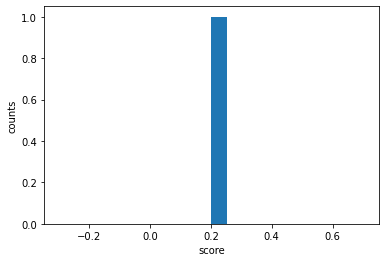

In [39]:
print("Roug Score:")
r = Rouge()
score_klsum=r.get_scores(summary_kl_sum, original_text)

file = open('klsum__org.txt', 'w')
file.write(original_text)
file.close()

file = open('klsum_hyps.txt', 'w')
file.write(summary_kl_sum)
file.close()


with open("klsum_hyps.txt") as f:
    cands_kl = [line.strip() for line in f]

with open("klsum__org.txt") as f:
    refs_kl = [[line.strip() for line in f]]


print('BLEU score -> {}'.format(sentence_bleu(refs_kl, cands_kl)))
blue_score_klsum=sentence_bleu(refs_kl, cands_kl)

print("Bert Score:")

if len(cands_kl)==1:
    P, R, F1 = score(cands_kl, refs_kl, lang='en', rescale_with_baseline=True)
    F1_kl=F1
    plt.hist(F1, bins=20)
    plt.xlabel("score")
    plt.ylabel("counts")
    plt.show()
if len(cands_kl)>1:
    scorer = BERTScorer(lang="en", rescale_with_baseline=True)
    P, R, F1 = scorer.score(cands_kl, refs_kl)
    F1_kl=F1
    plt.hist(F1, bins=20)
    plt.xlabel("score")
    plt.ylabel("counts")
    plt.show()

In [40]:
import pandas as pd

In [47]:
#wrap rouge score in dataframe
df_textRank = pd.DataFrame(score_text[0]['rouge-1'], index=['Text Rank']).apply(lambda x: round(x,3))
df_lexRank = pd.DataFrame(score_lexRank[0]['rouge-1'], index=['Lex Rank']).apply(lambda x: round(x,3))
df_lsa = pd.DataFrame(score_lsa[0]['rouge-1'], index=['LSA']).apply(lambda x: round(x,3))
df_luhan = pd.DataFrame(score_luhan[0]['rouge-1'], index=['Luhan']).apply(lambda x: round(x,3))
df_klsum = pd.DataFrame(score_klsum[0]['rouge-1'], index=['KL Sum']).apply(lambda x: round(x,3))
#concatenate and display
df_all_rough1= pd.concat([df_textRank, df_lexRank, df_lsa,df_luhan,df_klsum]) 
df_all_rough1.columns.name = 'ROUGE-1'
df_all_rough1.index.name = 'All'
df_all_rough1[['f', 'p', 'r']]

ROUGE-1,f,p,r
All,,,
Text Rank,0.413,1.000,0.260
Lex Rank,0.277,1.000,0.161
LSA,0.238,1.000,0.135
Luhan,0.462,1.000,0.301
KL Sum,0.212,0.996,0.118


In [48]:
#wrap rouge score in dataframe
df_textRank = pd.DataFrame(score_text[0]['rouge-2'], index=['Text Rank']).apply(lambda x: round(x,3))
df_lexRank = pd.DataFrame(score_lexRank[0]['rouge-2'], index=['Lex Rank']).apply(lambda x: round(x,3))
df_lsa = pd.DataFrame(score_lsa[0]['rouge-2'], index=['LSA']).apply(lambda x: round(x,3))
df_luhan = pd.DataFrame(score_luhan[0]['rouge-2'], index=['Luhan']).apply(lambda x: round(x,3))
df_klsum = pd.DataFrame(score_klsum[0]['rouge-2'], index=['KL Sum']).apply(lambda x: round(x,3))
#concatenate and display
df_all_rough2= pd.concat([df_textRank, df_lexRank, df_lsa,df_luhan,df_klsum]) 
df_all_rough2.columns.name = 'ROUGE-2'
df_all_rough2.index.name = 'All'
df_all_rough2[['f', 'p', 'r']]

ROUGE-2,f,p,r
All,,,
Text Rank,0.392,0.951,0.247
Lex Rank,0.269,0.973,0.156
LSA,0.230,0.972,0.131
Luhan,0.458,0.991,0.298
KL Sum,0.203,0.959,0.114


In [49]:
#wrap rouge score in dataframe
df_textRank = pd.DataFrame(score_text[0]['rouge-l'], index=['Text Rank']).apply(lambda x: round(x,3))
df_lexRank = pd.DataFrame(score_lexRank[0]['rouge-l'], index=['Lex Rank']).apply(lambda x: round(x,3))
df_lsa = pd.DataFrame(score_lsa[0]['rouge-l'], index=['LSA']).apply(lambda x: round(x,3))
df_luhan = pd.DataFrame(score_luhan[0]['rouge-l'], index=['Luhan']).apply(lambda x: round(x,3))
df_klsum = pd.DataFrame(score_klsum[0]['rouge-l'], index=['KL Sum']).apply(lambda x: round(x,3))
#concatenate and display
df_all_roughL= pd.concat([df_textRank, df_lexRank, df_lsa,df_luhan,df_klsum]) 
df_all_roughL.columns.name = 'ROUGE-L'
df_all_roughL.index.name = 'All'
df_all_roughL[['f', 'p', 'r']]

ROUGE-L,f,p,r
All,,,
Text Rank,0.479,1.000,0.315
Lex Rank,0.372,1.000,0.229
LSA,0.348,1.000,0.211
Luhan,0.567,1.000,0.395
KL Sum,0.332,0.994,0.199


In [53]:
df_all_rough1
df_all_rough2
df_all_roughL

ROUGE-1,f,p,r
All,,,
Text Rank,0.413,1.000,0.260
Lex Rank,0.277,1.000,0.161
LSA,0.238,1.000,0.135
Luhan,0.462,1.000,0.301
KL Sum,0.212,0.996,0.118


ROUGE-2,f,p,r
All,,,
Text Rank,0.392,0.951,0.247
Lex Rank,0.269,0.973,0.156
LSA,0.230,0.972,0.131
Luhan,0.458,0.991,0.298
KL Sum,0.203,0.959,0.114


ROUGE-L,f,p,r
All,,,
Text Rank,0.479,1.000,0.315
Lex Rank,0.372,1.000,0.229
LSA,0.348,1.000,0.211
Luhan,0.567,1.000,0.395
KL Sum,0.332,0.994,0.199


In [44]:
print("Blue Score: ")

print('Text Rank: '+str(blue_score_textrank))
print('Lex Rank: '+str(blue_score_lex))
print('LSA: '+str(blue_score_lsa))
print('Luhn: '+str(blue_score_luhan))
print('KL Sum: '+str(blue_score_klsum))

Blue Score: 
Text Rank: 5.037094777266818e-156
Lex Rank: 0
LSA: 0
Luhn: 0
KL Sum: 0


In [45]:
textRank=tf.constant(F1_textrank).numpy()
lex=tf.constant(F1_lex).numpy()
lsa=tf.constant(F1_lsa).numpy()
luhn=tf.constant(F1_luhan).numpy()
kl=tf.constant(F1_kl).numpy()


In [46]:
print("BERT Score:")
print('Text Rank: '+str(textRank))
print('Lex Rank: '+str(lex))
print('LSA: '+str(lsa))
print('Luhn: '+str(luhn))
print('KL Sum: '+str(kl))

BERT Score:
Text Rank: [1.]
Lex Rank: [0.16667655]
LSA: [0.16026878]
Luhn: [0.08607864]
KL Sum: [0.20216085]
